In [18]:
# default_exp metrics

In [19]:
# hide
import sys

sys.path.append("..")
import pandas as pd

# Metrics

> Metrics to evaluate time-series.

Mostly copied from <https://github.com/MSRDL/Deep4Cast>

In [20]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [21]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastseq.data.external import *
from fastseq.data.load import *
from fastseq.data.core import *
from fastseq.core import *

In [22]:
# export

def mape(truth, pred, reduction='mean') -> tensor:
    """Computes mean absolute percentage error (MAPE)
    """
    norm = torch.abs(truth)
    ret= torch.div(torch.abs(pred - truth), norm)

    if reduction != 'none':
        ret = torch.mean(ret) if reduction == 'mean' else torch.sum(ret)
    return ret

In [23]:
# hide
output = torch.sigmoid(torch.randn(32, 100,requires_grad=True))
target = torch.randint(0,2,(32, 100)).float()
test_eq(mape(output,target).shape,[])
test_eq(mape(output,target,reduction='mean').shape,[])
test_eq(mape(output,target,reduction='sum').shape,[])
test_eq(mape(output,target,reduction='none').shape,[32,100])

In [24]:
def np_smape(a, b):
    """
    Calculates sMAPE
    :param a: actual values
    :param b: predicted values
    :return: sMAPE
    """
    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return np.mean(2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b) + 1e-16))   # BT changed 2 to 200

In [25]:
def torch_smape(model_outputs,target_outputs):
    numerator = torch.abs(model_outputs - target_outputs)
    denominator = torch.abs(model_outputs) + torch.abs(target_outputs)
    elementwise_smape = 2*torch.div(numerator, denominator)
    nan_mask = torch.isnan(elementwise_smape)
    loss = elementwise_smape[~nan_mask].mean()    
    assert ~torch.isnan(loss)
    return loss

In [26]:
# export
def smape(truth, pred, agg=None, reduction='mean') -> tensor:
    """Computes symmetric mean absolute percentage error (SMAPE) on the mean

    Arguments:
        * data_samples (``np.array``): Sampled predictions (n_timeseries, n_variables, n_timesteps).
        * data_truth (``np.array``): Ground truth time series values (n_timeseries, n_variables, n_timesteps).
        * agg: Aggregation function applied to sampled predictions (defaults to ``np.median``).
    """
    if pred.shape != truth.shape:
        raise ValueError('Last three dimensions of data_samples and data_truth need to be compatible')

    eps = 1e-16  # Need to make sure that denominator is not zero
    norm = (torch.abs(pred) + torch.abs(truth)) + eps
    ret = (2.0 * torch.abs(pred - truth) / norm)

    if reduction != 'none':
        ret = torch.mean(ret) if reduction == 'mean' else torch.sum(ret)
    return ret

def SMAPELossFlat(*args, axis=-1, floatify=True, **kwargs):
    """Same as `smape`, but flattens input and target.
    DOES not work yet
    """
    return BaseLoss(smape, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

In [27]:
# hide
output = torch.sigmoid(torch.randn(32, 100,requires_grad=True))
target = torch.randint(0,2,(32, 100)).float()
test_eq(smape(output,target).shape,[])
test_eq(smape(output,target,reduction='mean').shape,[])
test_eq(smape(output,target,reduction='sum').shape,[])
test_eq(smape(output,target,reduction='none').shape,[32,100])

In [28]:
# hide
test_eq(F.mse_loss(output,target).shape,[])
test_eq(F.mse_loss(output,target,reduction='mean').shape,[])
test_eq(F.mse_loss(output,target,reduction='sum').shape,[])
test_eq(F.mse_loss(output,target,reduction='none').shape,[32,100])

In [29]:
# hide
for l in [100,10]:
    res={}
    for er in np.arange(.5,1.5,.05):
        res[er] = {}
        noise,y = torch.randn(64,1,l) * er, torch.cat([torch.arange(-(l/2),(l/2))[None,None,:]]*64,0)
        y_hat = y + noise
        smp = 0
        for i in range(64):
             smp += np_smape(y[i,:].numpy(),y_hat[i,:].numpy()) 
                
        test_close(smape(y,y_hat, reduction='sum').numpy(), l*smp,.02)
        test_close(smape(y,y_hat, reduction='mean'), torch_smape(y,y_hat))
        test_eq(smape(y,y_hat, reduction='mean').shape,())

y_hat: 0.7253458499908447
y_hat2:1.0276468992233276


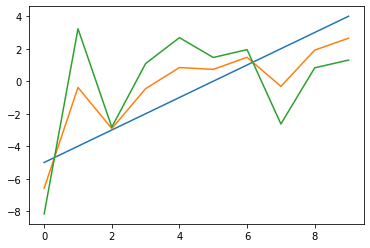

In [30]:
y_hat2 = noise + y_hat
plt.plot(np.arange(10),y[0,0])
plt.plot(np.arange(10),y_hat[0,0])
plt.plot(np.arange(10),y_hat2[0,0])
print(f"y_hat: {smape(y,y_hat,reduction='mean')}")
print(f"y_hat2:{smape(y,y_hat2,reduction='mean')}")

In [31]:
# hide
test_eq(smape(y,y_hat,reduction='mean')<smape(y,y_hat2,reduction='mean'),True)

In [32]:
def np_mase(y_test, y_hat_test,insample, freq):
    """
    Calculates MAsE
    :param insample: insample data
    :param y_test: out of sample target values
    :param y_hat_test: predicted values
    :param freq: data frequency
    :return:
    """
    y_hat_naive = []
    for i in range(freq, len(insample)):
        y_hat_naive.append(insample[(i - freq)])
    
    masep = np.mean(abs(insample[freq:] - y_hat_naive))
    return np.mean(abs(y_test - y_hat_test)) / masep


In [33]:
# export

def mase(y_test, y_hat_test, insample, freq, reduction=None):
    """Computes mean absolute scaled error (MASE) as in the `M4 competition
    <https://www.m4.unic.ac.cy/wp-content/uploads/2018/03/M4-Competitors-Guide.pdf>`_.
    Arguments:
        *

    """
    eps = 1e-16  # Need to make sure that denominator is not zero
    # Calculate mean absolute for forecast and naive forecast per time series
    err = torch.abs(y_test - y_hat_test)

    naive_forecast = insample[:, :-freq]
    naive_target = insample[:, freq:]
    naive_err = torch.abs(naive_target - naive_forecast).mean(-1)[:,None]
    ret = torch.div(err, naive_err+eps).mean(-1)
    if reduction is not None:
        ret = torch.mean(ret,-1) if reduction == 'mean' else torch.sum(ret,-1)
    return ret

In [34]:
# hide
for l in [114, 1014]:
    res={}
    horizon = 14
    for er in np.arange(.5,1.5,.05):
        res[er] = {}
        noise,x = torch.randn(64, 1, l) * er, torch.cat([torch.arange(-(l/2),(l/2))[None,None,:]] * 64,0)
        y_hat = x + noise      
        y = x
        smp = 0
        for i in range(64):
            smp += np_mase(x[i, 0, -horizon:].numpy(), y_hat[i, 0, -horizon:].numpy(), x[i, 0, :-horizon].numpy(), 7)
        
        my = mase( x[:, 0, -horizon:], y_hat[:, 0, -horizon:],x[:, 0, :-horizon], 7, reduction = 'sum')
        test_close(my, smp)
        test_eq(mase(x[:, 0, -horizon:], y_hat[:, 0, -horizon:],x[:, 0, :-horizon], 7, reduction = 'mean').shape,())


y_hat: 0.20445282757282257
y_hat2:0.40890565514564514


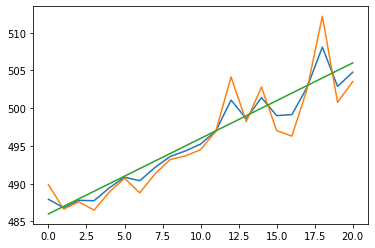

In [35]:
y_hat2=noise + y_hat
plt.plot(np.arange(21),y_hat[0,0,-21:])
plt.plot(np.arange(21),y_hat2[0,0,-21:])
plt.plot(np.arange(21),y[0,0,-21:])
err_y_hat =  mase(x[0, 0, -horizon:][None,:], y_hat [0, 0, -horizon:][None,:], x[0, 0, :-horizon][None,:], 7, reduction = 'mean')
err_y_hat2 = mase(x[0, 0, -horizon:][None,:], y_hat2[0, 0, -horizon:][None,:],x[0, 0, :-horizon][None,:], 7, reduction = 'mean')
print(f"y_hat: {err_y_hat}")
print(f"y_hat2:{err_y_hat2}")

In [36]:
# hide
test_eq(err_y_hat<err_y_hat2, True)

In [37]:
# hide
class MASE(Module):
    def __init__(self, freq, *args, **kwargs):
        self.freq = freq 
        self.x_sample = None
        
    def forward(self, inp, targ, **kwargs):
        assert self.x_sample is not None, f"Please use also use the `MASECallback` callback."
        return mase(inp, targ, self.x_sample, freq)
    
class MASECallback(Callback):
    def after_pred(self):
        if isinstance(self.learn.loss_func,MASE):
            self.learn.loss_func.x_sample = self.xb
        

In [38]:
# hide
from fastai2.test_utils import *

def synth_learner(n_train=10, n_valid=2, cuda=False, lr=.01, **kwargs):
    data = synth_dbunch(n_train=n_train,n_valid=n_valid, cuda=cuda)
    return Learner(data, RegModel(), loss_func=MASE(), lr=lr, cbs=MASECallback())

# tst_learn = synth_learner()
# tst_learn.fit(1,0.01)


In [39]:
#hide
#cuda
#Test losses work in half precision
# output = torch.sigmoid(torch.randn(32, 5, 10)).half().cuda()
# target = torch.randint(0,2,(32, 5, 10)).half().cuda()
# for tst in [SMAPELossFlat(), MSELossFlat()]: 
#     _ = tst(output, target)

## Metrics Parts

In [40]:
#export
from fastai2.basics import *
class NBeatsLossPart(Metric):
    "The loss according to the `loss_func` on a particular part of the time-serie."
    def __init__(self, start, end, name, *args, loss_func=None, **kwargs):
        store_attr(self,"start,end,loss_func")
        self._name = name

    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)
        if self.loss_func is None:
            self.loss_func = learn.loss_func
        pred, truth = learn.pred, learn.yb[0]
        if len(pred.shape) == 2:
            pred = pred[:,None,:]
            truth = truth[:,None,:]
        assert pred[:,0,self.start:self.end].shape == truth[:,0,self.start:self.end].shape
        loss = to_detach(self.loss_func(pred[:,0,self.start:self.end], truth[:,0,self.start:self.end])) / truth[:,0,self.start:self.end].shape[-1]
        self.total += loss.mean()*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return self._name

In [41]:
#export
class NBeatsBackward(NBeatsLossPart):
    "The loss according to the `loss_func` on the backwards part of the time-serie."
    def __init__(self, lookback, *args, **kwargs):
        super().__init__(0, lookback, 'b_loss', *args, **kwargs)

In [42]:
# hide
horizon, lookback = 5,20
items = dummy_data_generator(50, 10, nrows=10)
data = TSDataLoaders.from_items(items, horizon = horizon,lookback = lookback, bs=32)
mdl = NBeatsNet(device = data.train.device, horizon=horizon, lookback=lookback, layers = [100])
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, #metrics=[NBeatsBackward(lookback)],
#                 cbs=L(NBeatsTrainer())
               )
learn.loss_func
learn.fit(2,.1)

NameError: name 'TSDataLoaders' is not defined

In [ ]:
#export
class NBeatsForward(NBeatsLossPart):
    "The loss according to the `loss_func` on the forward part of the time-serie."
    def __init__(self, lookback, *args, **kwargs):
        super().__init__(lookback, None, 'f_loss', *args, **kwargs)

In [ ]:
# export
from fastai2.basics import *
class LossPart(Metric):
    "The loss according to the `loss_func` on a particular part of the time-serie."
    def __init__(self, start, end, name, *args, loss_func=None, **kwargs):
        store_attr(self,"start,end,loss_func")
        self._name = name

    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)
        if self.loss_func is None:
            self.loss_func = learn.loss_func
        pred, truth = learn.pred, learn.yb[0]
        if len(pred.shape) == 2:
            pred = pred[:,None,:]
            truth = truth[:,None,:]
        assert pred[:,0,self.start:self.end].shape == truth[:,0,self.start:self.end].shape
        loss = to_detach(self.loss_func(pred[:,0,self.start:self.end],
                                        truth[:,0,self.start:self.end])) / truth[:,0,self.start:self.end].shape[-1]
        self.total += loss.mean()*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return self._name


In [ ]:
# export
def ForcastLoss(loss_func, lookback, ratio = [1,1]):
    def _inner(pred, truth, *args, **kwargs):
        if len(pred.shape) == 2:
            pred = pred[:,None,:]
            truth = truth[:,None,:]
        if kwargs.get('reduction', 'mean') == 'none':
            loss = torch.zeros_like(pred)
            loss[:,:,lookback:] += loss_func(pred[:,:,lookback:],truth[:,:,lookback:], *args, **kwargs) 
        else:
            loss = loss_func(pred[:,:,lookback:],truth[:,:,lookback:], *args, **kwargs)
        return loss

    return _inner

In [ ]:
# hide
from nbdev.export import *

notebook2script()